<a href="https://colab.research.google.com/github/richie-1/LSTM/blob/main/Assignment_3_DL_1_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np
import pandas as pd
import random
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import time
from tqdm import tqdm_notebook
import warnings
#warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import math
from sklearn.metrics import mean_squared_error

In [89]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization

In [90]:
url = 'https://raw.githubusercontent.com/richie-1/LSTM/main/Google_Stock_Price_Train.csv'
df = pd.read_csv(url, parse_dates=['Date'])

In [91]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
1,2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2,2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
3,2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
4,2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [92]:
df.shape

(1258, 6)

In [93]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close             object
Volume            object
dtype: object

In [94]:
df.replace(',','', regex=True, inplace=True)
df['Close'] = pd.to_numeric(df['Close'], downcast= 'float')
df['Volume'] = pd.to_numeric(df['Volume'], downcast= 'float')

In [95]:
df.isnull().any()

Date      False
Open      False
High      False
Low       False
Close     False
Volume    False
dtype: bool

In [96]:
df.describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.0
mean,533.709833,537.880223,529.007409,712.669678,3158107.0
std,151.904442,153.008811,150.552807,164.752609,2273726.0
min,279.120000,281.210000,277.220000,491.200012,7900.0
25%,404.115000,406.765000,401.765000,576.740021,1621700.0
50%,537.470000,540.750000,532.990000,695.675018,2566150.0
75%,654.922500,662.587500,644.800000,782.104980,4122500.0
max,816.680000,816.680000,805.140000,1216.829956,24977900.0


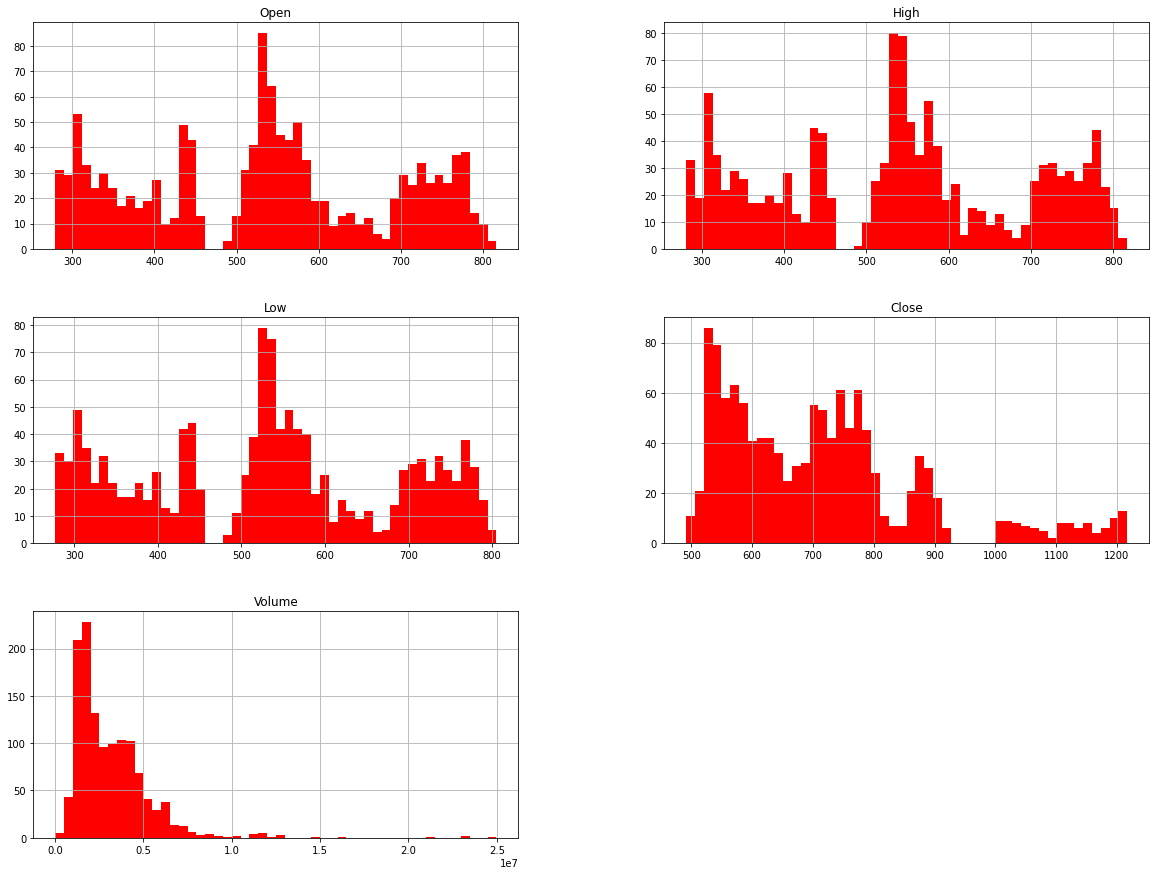

In [97]:
df.hist(bins=50, figsize=(20,15),color='red')
plt.show()

In [98]:
for i in range(len(df.Date)):
    if df.Close[i] > df.High[i]:
        df.Close[i] = df.Close[i] / 2.002

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
df.describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.0
mean,533.709833,537.880223,529.007409,533.289185,3158107.0
std,151.904442,153.008811,150.552807,151.866577,2273726.0
min,279.120000,281.210000,277.220000,278.481537,7900.0
25%,404.115000,406.765000,401.765000,403.759987,1621700.0
50%,537.470000,540.750000,532.990000,537.410004,2566150.0
75%,654.922500,662.587500,644.800000,652.172485,4122500.0
max,816.680000,816.680000,805.140000,813.109985,24977900.0


In [100]:
df

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,331.463562,7380500.0
1,2012-01-04,331.27,333.87,329.08,332.892120,5749400.0
2,2012-01-05,329.83,330.75,326.89,328.276733,6590300.0
3,2012-01-06,328.34,328.77,323.68,323.796204,5405900.0
4,2012-01-09,322.04,322.29,309.46,310.069946,11688800.0
...,...,...,...,...,...,...
1253,2016-12-23,790.90,792.74,787.28,789.909973,623400.0
1254,2016-12-27,790.68,797.86,787.66,791.549988,789100.0
1255,2016-12-28,793.70,794.23,783.20,785.049988,1153800.0
1256,2016-12-29,783.33,785.93,778.92,782.789978,744300.0


In [101]:
df = df.sort_values(by='Date')

In [102]:
df['month'] = df['Date'].dt.month

In [103]:
df

,Date,Open,High,Low,Close,Volume,month
0,2012-01-03,325.25,332.83,324.97,331.463562,7380500.0,1
1,2012-01-04,331.27,333.87,329.08,332.892120,5749400.0,1
2,2012-01-05,329.83,330.75,326.89,328.276733,6590300.0,1
3,2012-01-06,328.34,328.77,323.68,323.796204,5405900.0,1
4,2012-01-09,322.04,322.29,309.46,310.069946,11688800.0,1
...,...,...,...,...,...,...,...
1253,2016-12-23,790.90,792.74,787.28,789.909973,623400.0,12
1254,2016-12-27,790.68,797.86,787.66,791.549988,789100.0,12
1255,2016-12-28,793.70,794.23,783.20,785.049988,1153800.0,12
1256,2016-12-29,783.33,785.93,778.92,782.789978,744300.0,12


In [104]:
len(df.Date)

1258

Text(0, 0.5, 'Close price')

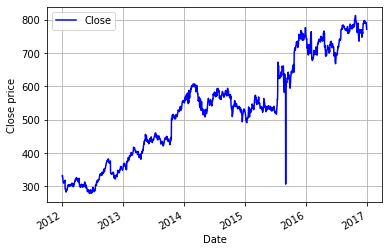

In [105]:
plt.figsize = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Close', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("Close price")

In [106]:
for i in range(len(df.Date)):
    if df.Close[i] < df.Low[i]:
        print('data at point',i,df.Close[i])

data at point 248 348.69632
data at point 741 517.24
data at point 874 535.23
data at point 922 306.86316
data at point 1179 759.66


In [107]:
print('location 741 data : \n',df.iloc[741], '\n')
print('location 874 data : \n',df.iloc[874], '\n')
print('location 922 data : \n',df.iloc[922], '\n')
print('location 1179 data : \n',df.iloc[1179], '\n')

location 741 data : 
 Date      2014-12-12 00:00:00
Open                   522.08
High                   527.05
Low                    517.24
Close                  517.24
Volume             1.9945e+06
month                      12
Name: 741, dtype: object 

location 874 data : 
 Date      2015-06-25 00:00:00
Open                   538.87
High                    540.9
Low                    535.23
Close                  535.23
Volume             1.3357e+06
month                       6
Name: 874, dtype: object 

location 922 data : 
 Date      2015-09-02 00:00:00
Open                   605.59
High                   614.34
Low                    599.71
Close                 306.863
Volume             2.5756e+06
month                       9
Name: 922, dtype: object 

location 1179 data : 
 Date      2016-09-09 00:00:00
Open                    770.1
High                   773.24
Low                    759.66
Close                  759.66
Volume             1.8855e+06
month               

In [108]:
df = df.drop(922)

Text(0, 0.5, 'Close Price')

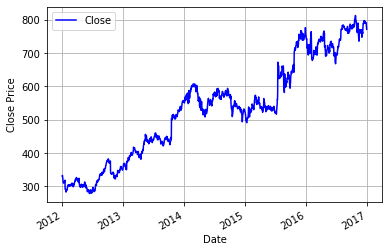

In [109]:
plt.figsize = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Close', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")

### Split into train and validation

In [110]:
val_size = int(0.10*len(df.Date))
val_size

125

In [111]:
train_size = len(df.Date)- val_size
train_size

1132

In [112]:
df_train = df[:train_size][['Date', 'Close']]
df_val = df[train_size:train_size+val_size][['Date', 'Close']]

In [113]:
df_full = df[['Date', 'Close']]

In [114]:
df_val

,Date,Close
1133,2016-07-06,697.770020
1134,2016-07-07,695.359985
1135,2016-07-08,705.630005
1136,2016-07-11,715.090027
1137,2016-07-12,720.640015
...,...,...
1253,2016-12-23,789.909973
1254,2016-12-27,791.549988
1255,2016-12-28,785.049988
1256,2016-12-29,782.789978


### Scaling data

In [115]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(np.array(df_train['Close']).reshape(-1,1))
val_sc = sc.fit_transform(np.array(df_val['Close']).reshape(-1,1))

In [116]:
# No of days 
N = 10

In [117]:
def x_y(data, N, o):    
    #Split data into x and y    
    x, y = [], []
    for i in range(o, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [118]:
x_train_sc, y_train_sc = x_y(train_sc, N, N)

In [119]:
def x__y(data, N, o):
    x_sc, y, m, std = [],[],[],[]
    for i in range(o, len(data)):
        m.append(np.mean(data[i-N:i]))
        std.append(np.std(data[i-N:i]))
        x_sc.append((data[i-N:i] - m[i-o]) / std[i-o])
        y.append(data[i])
    x_sc = np.array(x_sc)
    y = np.array(y)
    
    return x_sc, y, m, std

In [120]:
x_val_sc, y_val_sc, mu_val, std_val = x__y(np.array(df_full['Close']).reshape(-1,1), N, train_size)

### LSTM

In [121]:
lstm_units=50                  
dropout_prob=0.2                 
optimizer='adam'
epochs=50                       
batch_size=1   



In [122]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_sc.shape[1],1)))
model.add(Dropout(dropout_prob)) 
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_sc, y_train_sc, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/50
1122/1122 - 4s - loss: 0.0063
Epoch 2/50
1122/1122 - 4s - loss: 0.0046
Epoch 3/50
1122/1122 - 4s - loss: 0.0033
Epoch 4/50
1122/1122 - 4s - loss: 0.0029
Epoch 5/50
1122/1122 - 4s - loss: 0.0024
Epoch 6/50
1122/1122 - 4s - loss: 0.0022
Epoch 7/50
1122/1122 - 4s - loss: 0.0019
Epoch 8/50
1122/1122 - 4s - loss: 0.0021
Epoch 9/50
1122/1122 - 4s - loss: 0.0018
Epoch 10/50
1122/1122 - 4s - loss: 0.0016
Epoch 11/50
1122/1122 - 4s - loss: 0.0016
Epoch 12/50
1122/1122 - 4s - loss: 0.0017
Epoch 13/50
1122/1122 - 4s - loss: 0.0017
Epoch 14/50
1122/1122 - 4s - loss: 0.0015
Epoch 15/50
1122/1122 - 4s - loss: 0.0015
Epoch 16/50
1122/1122 - 4s - loss: 0.0014
Epoch 17/50
1122/1122 - 4s - loss: 0.0014
Epoch 18/50
1122/1122 - 4s - loss: 0.0016
Epoch 19/50
1122/1122 - 4s - loss: 0.0013
Epoch 20/50
1122/1122 - 4s - loss: 0.0014
Epoch 21/50
1122/1122 - 4s - loss: 0.0013
Epoch 22/50
1122/1122 - 4s - loss: 0.0014
Epoch 23/50
1122/1122 - 4s - loss: 0.0013
Epoch 24/50
1122/1122 - 4s - loss: 0.0013
E

In [123]:
# Print model summary
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 10, 50)            10400     
_________________________________________________________________
dropout_63 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_64 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [124]:
y_pred = model.predict(x_val_sc)
y_p = (y_pred * np.array(std_val).reshape(-1,1)) + np.array(mu_val).reshape(-1,1)
print("Shape = ", (y_p.shape))

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_val_sc, y_p))
print("RMSE = ", rmse)

Shape =  (125, 1)
RMSE =  9.676930426685425


In [126]:
df_pred = pd.DataFrame({'y_p': y_p.reshape(-1),
                       'Date': df_val['Date']})

Text(0, 0.5, 'Close')

<Figure size 360x360 with 0 Axes>

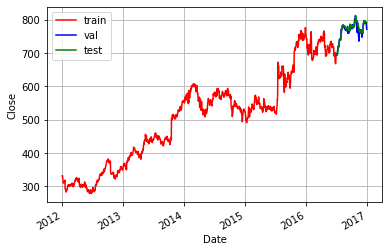

In [127]:
ax = plt.figure(figsize=(5,5))
ax = df_train.plot(x='Date',y='Close', style='r-', grid=True)
ax = df_val.plot(x='Date',y='Close', style='b-', grid=True, ax=ax)
ax = df_pred.plot(x='Date', y='y_p', style='g-', grid=True, ax=ax)
ax.legend(['train', 'val', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("Close")

In [128]:
def model(x_train_sc, y_train_sc, x_val_sc, y_val_sc, m, std, 
          lstm_units, dropout_prob, optimizer='adam', epochs=1, batch_size=1):
    
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units,return_sequences=True, input_shape=(x_train_sc.shape[1],1)))
    model.add(Dropout(dropout_prob)) 
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) 
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_sc, y_train_sc, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Prediction
    y_pred = model.predict(x_val_sc)
    y_p = (y_pred * np.array(std).reshape(-1,1)) + np.array(m).reshape(-1,1)
    
    rmse = math.sqrt(mean_squared_error(y_val_sc, y_p))
    
    return rmse

### Tuning

In [129]:
N=10
x_train_sc, y_train_sc = x_y(train_sc, N, N)
x_val_sc, y_val_sc, m, std = x__y(np.array(df_full['Close']).reshape(-1,1), N, train_size)

In [130]:
p1_label = 'lstm_units'
p1 = [10, 32, 50, 64, 128]

p2_label = 'dropout_prob'
p2 = [0.2, 0.5, 0.6, 0.7, 0.8, 0.9]

output = {p1_label: [], p2_label: [], 'rmse': []}
start = time.time()
for param in p1:
    for param2 in p2:
        # Train model
        rmse = model(x_train_sc, y_train_sc, x_val_sc, y_val_sc, m, std, 
                    lstm_units=param, dropout_prob=param2, optimizer=optimizer, 
                    epochs=epochs, batch_size=batch_size)
        output[p1_label].append(param)
        output[p2_label].append(param2)
        output['rmse'].append(rmse)
end = time.time()

In [131]:
output = pd.DataFrame(output)
print("Time taken = ", str((end-start)/60.0), "minutes")
print(output)

Time taken =  90.06555351018906 minutes
    lstm_units  dropout_prob       rmse
0           10           0.2  10.661097
1           10           0.5  12.085043
2           10           0.6  12.588331
3           10           0.7  13.510065
4           10           0.8  13.518815
5           10           0.9  13.434697
6           32           0.2   9.476239
7           32           0.5  10.640165
8           32           0.6  11.464290
9           32           0.7  12.015928
10          32           0.8  12.624712
11          32           0.9  13.618939
12          50           0.2   9.819341
13          50           0.5  10.471557
14          50           0.6  10.947340
15          50           0.7  11.570543
16          50           0.8  12.294441
17          50           0.9  13.337755
18          64           0.2   9.925140
19          64           0.5  10.611329
20          64           0.6  10.929054
21          64           0.7  11.775085
22          64           0.8  12.125935


In [132]:
output

,lstm_units,dropout_prob,rmse
0,10,0.2,10.661097
1,10,0.5,12.085043
2,10,0.6,12.588331
3,10,0.7,13.510065
4,10,0.8,13.518815
5,10,0.9,13.434697
6,32,0.2,9.476239
7,32,0.5,10.640165
8,32,0.6,11.464290
9,32,0.7,12.015928


In [133]:
# Get optimum value for param and param2
temp = output[output['rmse'] == output['rmse'].min()]
lstm_units_final = temp[p1_label].values[0]
dropout_prob_final = temp[p2_label].values[0]
print("min RMSE = %0.3f" % output['rmse'].min())
print("optimum ", p1_label , " = ", str(lstm_units_final))
print("optimum ", p2_label , " = ", str(dropout_prob_final))

min RMSE = 9.476
optimum  lstm_units  =  32
optimum  dropout_prob  =  0.2


In [134]:
p_label = 'optimizer'
p_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

output2 = {p_label: [], 'rmse': []}
start2 = time.time()
for param in p_list:
    rmse = model(x_train_sc, y_train_sc, x_val_sc, y_val_sc, m, std, 
                    lstm_units=lstm_units_final, dropout_prob=dropout_prob_final, optimizer=param, 
                    epochs=epochs, batch_size=batch_size)
    # Collect results
    output2[p_label].append(param)
    output2['rmse'].append(rmse)
end2 = time.time()

In [135]:
output2 = pd.DataFrame(output2)
print("Time taken = ", str((end2-start2)/60.0), "minutes")
print(output2)

Time taken =  23.239992972215017 minutes
  optimizer       rmse
0      adam   9.356405
1       sgd  13.984245
2   rmsprop  10.112763
3   adagrad  14.909684
4  adadelta  14.846204
5    adamax  10.742085
6     nadam   9.058347


In [136]:
temp2 = output2[output2['rmse'] == output2['rmse'].min()]
optimizer_final = temp2[p_label].values[0]
print("min RMSE = %0.3f" % output2['rmse'].min())
print("optimum ", p_label , " = ", str(optimizer_final))

min RMSE = 9.058
optimum  optimizer  =  nadam
